# Forward Modelling of a Simple Glacier

In [36]:
#import libraries
import numpy as np
import matplotlib.pyplot as plt

from simpeg import maps
import simpeg.electromagnetics.time_domain as tdem
from simpeg.utils import plot_1d_layer_model

### Step 1. Survey Set-Up
**Extremely important note!**
Blatter et al (2018) reports the data as resistivity values (Ohm m) whereas the simpeg functions use conductivity values! reciprocals of resisivities must be taken in order to recreate the results.

In [51]:
#specify parameters

#conductivities
ice_sigma = 1/10**4 #taken from reference paper
nonice_sigma = 1/10**3
wet_sigma = 1/10**1 
sigmas = np.r_[ice_sigma, nonice_sigma, nonice_sigma]
sigma_layers = np.r_[ice_sigma, wet_sigma, nonice_sigma]

#layer thickness
glacier_z = 150 #from reference paper
total_z = 350
non_glacier_z = total_z - glacier_z

thickness = np.r_[glacier_z,non_glacier_z]
thickness_layers = np.r_[glacier_z, 50, 400]

#number of layers
n_layers = len(sigmas) #2 layer model
n_layers3 = len(sigma_layers) #3 layer model

# Source properties
source_location = np.array([0.0, 0.0, 35.0]) #m
source_orientation = "z"  # "x", "y" or "z"
source_current = 500  #A
source_radius = np.sqrt(499/np.pi) #m, approximation from a octagon

#transmitter moment for normalisation
moment = source_current * 499 #m^-2 A^-1

# Receiver properties
receiver_locations = np.array([0.0, 0.0, 1.0])  # or (N, 3) numpy.ndarray
receiver_orientation = "z"  # "x", "y" or "z"
times = np.logspace(-5, -2, 31)  # time channels (s), from reference paper
time_layers = np.logspace(-5, -2, 31) + 0.05*np.random.randn(len(times))

### Step 2: Make Models

This step defines the "true model" or the model that we will test our inversions against. Here I've decided to use a 2 or 3 layer model that has the ice, wet sediment and then the rock below. The model uses resistivity as the variable since there is a high contrast between water (extremely conductive, low resistivity) and ice (extremely resistive)

In [52]:
#define waveforms

#stepoff
stepoff_waveform = tdem.sources.StepOffWaveform(off_time=0.0)

#rectangular
eps = 6.5*(1e-6)
ramp_on = np.r_[-0.0008, -0.0008 + eps]
ramp_off = np.r_[-eps, 0.0]
rectangular_waveform = tdem.sources.TrapezoidWaveform(
    ramp_on=ramp_on, ramp_off=ramp_off
)

In [53]:
#define surveys 
receiver_list = []
receiver_list.append(
    tdem.receivers.PointMagneticFluxDensity(
        receiver_locations, times, orientation=receiver_orientation
    )
)

# Define source list. In our case, we have only a single source.
source_list = [
    tdem.sources.CircularLoop(
        receiver_list=receiver_list,
        location=source_location,
        waveform=rectangular_waveform,
        current=source_current,
        radius=source_radius,
    )
]

# Define the survey
survey = tdem.Survey(source_list)

In [54]:
#define surveys 
receiver_list_layers = []
receiver_list_layers.append(
    tdem.receivers.PointMagneticFluxDensity(
        receiver_locations, time_layers, orientation=receiver_orientation
    )
)

# Define source list. In our case, we have only a single source.
source_list_layers = [
    tdem.sources.CircularLoop(
        receiver_list=receiver_list_layers,
        location=source_location,
        waveform=rectangular_waveform,
        current=source_current,
        radius=source_radius,
    )
]

# Define the survey
survey_layers = tdem.Survey(source_list_layers)

Text(0.5, 1.0, 'True Model')

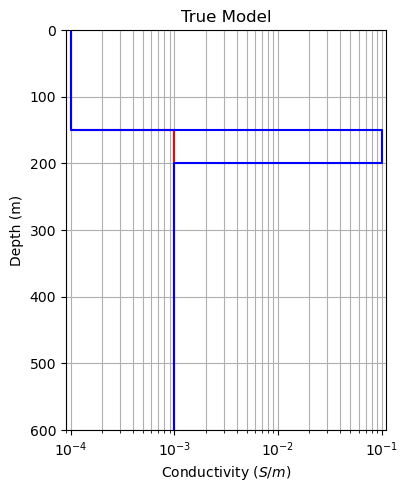

In [83]:
#Plot the model
fig = plt.figure(figsize=(4, 5))
ax1 = fig.add_axes([0.1, 0.1, 0.8, 0.8])
ax1 = plot_1d_layer_model(thickness, sigmas, scale="log", ax=ax1, color = "r")
ax1 = plot_1d_layer_model(thickness_layers, sigma_layers, scale="log", ax=ax1, color = "b")
ax1.grid(which="both")
ax1.set_xlabel(r"Conductivity ($S/m$)")
plt.title("True Model")

### Step 3. Forward Simulation

Using Time Domain Electromagnetics to plot the data response to the synthetic model. Data should be normalised by the magnetic moment of the transmitter loop (defined above in parameters) and should be differentiated with respect to the time variable.

In [56]:
#define map and model
model = sigmas.copy()
model_layers = sigma_layers.copy()
sig_map = maps.IdentityMap(nP=n_layers)
sig_map_layers = maps.IdentityMap(nP=n_layers3)

In [57]:
simulation = tdem.simulation_1d.Simulation1DLayered(survey=survey, sigmaMap= sig_map, thicknesses=thickness)
simulation_layers = tdem.simulation_1d.Simulation1DLayered(survey=survey_layers, 
                                                           sigmaMap= sig_map_layers, thicknesses=thickness_layers)

In [85]:
#predict data
dpred = simulation.dpred(model) #T
dpred_layers = simulation.dpred(model_layers)

#take differences to try and imi
d_dpred = np.diff(dpred)
d_dpred_layers = np.diff(dpred_layers)
dt = np.diff(times)

dBdt = d_dpred/dt #in Volt / m^2
dBdt_layers = d_dpred_layers/dt# + 1e-5*np.random.randn(len(times[1:]))

#divide by moment
dBdt_norm = dBdt/moment
dBdt_layers_norm = dBdt_layers/moment

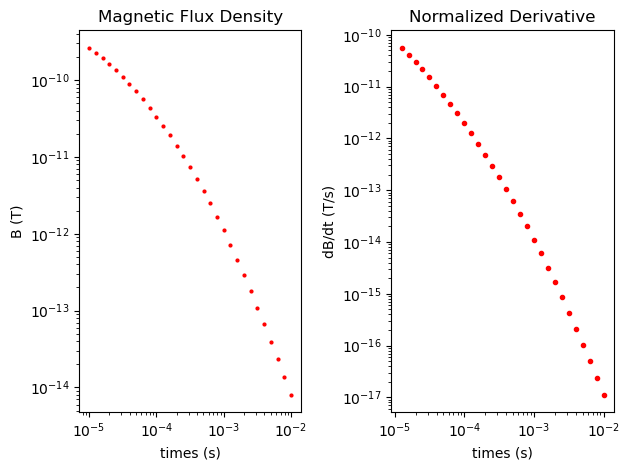

In [87]:
#Plot the predicted data
plt.subplot(1,2,1)
plt.loglog(times, dpred, "ro", markersize = 2)
plt.xlabel("times (s)")
plt.ylabel("B (T)")
plt.title("Magnetic Flux Density")

plt.subplot(1,2,2)
plt.loglog(times[1:], np.abs(dBdt_norm), "ro", markersize = 3)
plt.xlabel("times (s)")
plt.ylabel("dB/dt (T/s)")
plt.title("Normalized Derivative")

plt.tight_layout()

### Step 4. Make figure

Recreation of 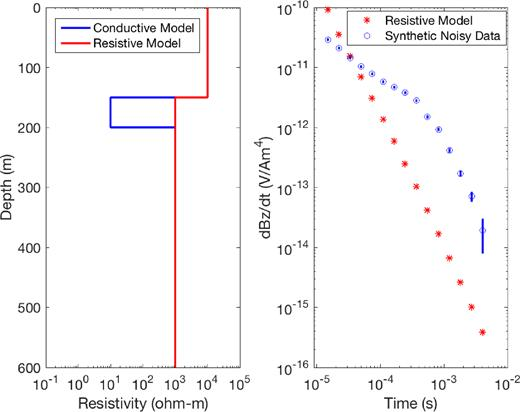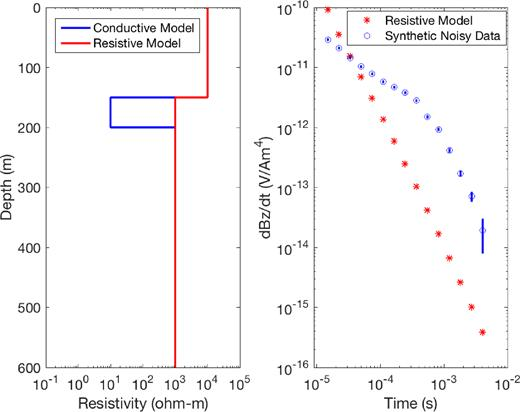

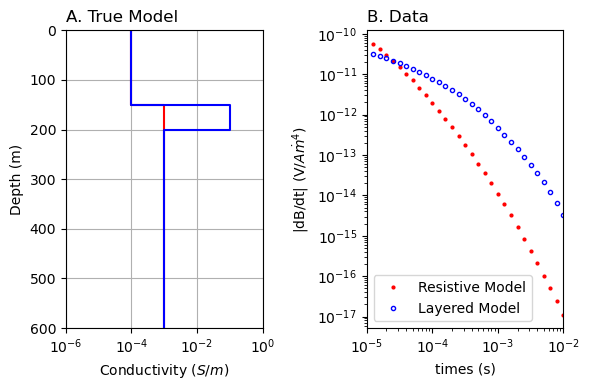

In [90]:
#make imitation of figure 2
#model
fig = plt.figure(figsize=(6, 4))
ax1 = plt.subplot(1,2,1)
ax1 = plot_1d_layer_model(thickness, sigmas, scale="log", ax=ax1, color = "r")
ax1 = plot_1d_layer_model(thickness_layers, sigma_layers, scale="log", ax=ax1, color = "b")
ax1.grid(which="both")
ax1.set_xlim(1e-6, 1)
ax1.set_xlabel(r"Conductivity ($S/m$)")
plt.title("A. True Model", loc = "left")

#data response
plt.subplot(1,2,2)
plt.loglog(times[1:], np.abs(dBdt_norm), "ro", markersize = 2, label = "Resistive Model")
plt.loglog(times[1:], np.abs(dBdt_layers_norm), "bo", fillstyle = "none", markersize = 3, label = "Layered Model")
plt.xlim(1e-5,1e-2)
plt.xlabel("times (s)")
plt.ylabel("|dB/dt| (V/$A \\dot m^4$)")
plt.title("B. Data", loc = "left")
plt.legend()

plt.tight_layout()